In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
from models import VqVaeEMA
from utils import compute_vq_loss, save, load
from IPython import display as ipd

from torchvision.datasets import stl10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [3]:
BATCH_SIZE = 8
ETA = 1e-3
EPOCHS = 500
BETA1 = 0.25
BETA2 = 0.25 # no effect

CODEBOOK_SIZE = 512
FEATURE_DIM = 256
N_RESID = 5

In [4]:
def train_step(context, x):
    model = context["model"]
    optimizer = context["optimizer"]
    
    model.train()
    
    optimizer.zero_grad()
    x_rec, z_e, z_q = model(x)
    loss_rec, loss_comm, loss_vq = compute_vq_loss(x, x_rec, z_e, z_q, EMA=True)
    loss = loss_rec + BETA1*loss_comm + BETA2*loss_vq
    
    loss.backward()
    optimizer.step()
    
    return x_rec, loss_rec.item(), loss_comm.item(), loss_vq.item()

In [5]:
def test_step(context, x):
    model = context["model"]
    model.eval()
    
    with torch.no_grad():
        x_rec, z_e, z_q = model(x)
        loss_rec, loss_comm, loss_vq = compute_vq_loss(x, x_rec, z_e, z_q, EMA=True)
    
    return x_rec, loss_rec.item(), loss_comm.item(), loss_vq.item()

In [6]:
def visualize(x, x_rec):
    N = x.size(0)
    
    x = x.detach().cpu().numpy().transpose(0, 2, 3, 1) + 0.5
    x_rec = x_rec.detach().cpu().numpy().transpose(0, 2, 3, 1) + 0.5
    
    x_rec[x_rec < 0] = 0
    x_rec[x_rec > 1] = 1
    
    for i in range(min(8, N)):
        plt.subplot(1, 2, 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        plt.title("Original Image")
        
        plt.subplot(1, 2, 2)
        plt.imshow(x_rec[i])
        plt.xticks([])
        plt.yticks([])
        plt.title("Reconstructed Image")
        
        plt.show()

In [7]:
def train():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
    ])
    
    trainloader = DataLoader(stl10.STL10("/data/conda/", "train", transform=transform, download=False), shuffle=True, batch_size=BATCH_SIZE)
    testloader = DataLoader(stl10.STL10("/data/conda/", "test", transform=transform, download=False), batch_size=BATCH_SIZE)
    
    model = VqVaeEMA(FEATURE_DIM, N_RESID, CODEBOOK_SIZE).cuda()
    optimizer = optim.Adam(model.parameters(), lr=ETA)
    
    context = {
        "model": model,
        "optimizer": optimizer
    }
    
    train_losses = []
    test_losses = []
    
    for e in range(EPOCHS):
        
        train_loss = [0., 0., 0.]
        test_loss = [0., 0., 0.]
        
        for x, _ in trainloader:
            x = x.cuda()
            ret = train_step(context, x)
            train_loss[0] += ret[1] / len(trainloader)
            train_loss[1] += ret[2] / len(trainloader)
            train_loss[2] += ret[3] / len(trainloader)
            
        for x, _ in testloader:
            x = x.cuda()
            ret = test_step(context, x)
            test_loss[0] += ret[1] / len(testloader)
            test_loss[1] += ret[2] / len(testloader)
            test_loss[2] += ret[3] / len(testloader)
            
        train_losses.append(train_loss)
        test_losses.append(test_loss)
            
        ipd.clear_output(wait=True)
            
        print(f"Epochs {e+1}/{EPOCHS}")
        print(f"Train loss:")
        print(f"\tLoss for reconstruction: {train_loss[0]:.8f}")
        print(f"\tLoss for commitment: {train_loss[1]:.8f}")
        print(f"\tLoss for vector quantization: {train_loss[2]:.8f}")
        print(f"Test loss:")
        print(f"\tLoss for reconstruction: {test_loss[0]:.8f}")
        print(f"\tLoss for commitment: {test_loss[1]:.8f}")
        print(f"\tLoss for vector quantization: {test_loss[2]:.8f}")
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.plot(list(map(lambda item: item[0], train_losses)))
        plt.title("Reconstruction train loss")
        plt.subplot(1, 3, 2)
        plt.plot(list(map(lambda item: item[1], train_losses)))
        plt.title("Commitment train loss")
        plt.subplot(1, 3, 3)
        plt.plot(list(map(lambda item: item[2], train_losses)))
        plt.title("Vector-quantization train loss")
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.plot(list(map(lambda item: item[0], test_losses)))
        plt.title("Reconstruction test loss")
        plt.subplot(1, 3, 2)
        plt.plot(list(map(lambda item: item[1], test_losses)))
        plt.title("Commitment test loss")
        plt.subplot(1, 3, 3)
        plt.plot(list(map(lambda item: item[2], test_losses)))
        plt.title("Vector-quantization test loss")
        plt.tight_layout()
        plt.show()
        
        visualize(x, ret[0])
        
        save(context, "ckpts/vqvae_ema.pt")

Epochs 500/500
Train loss:
	Loss for reconstruction: 0.04232699
	Loss for commitment: 0.02815569
	Loss for vector quantization: 0.00000000
Test loss:
	Loss for reconstruction: 0.04354639
	Loss for commitment: 0.02767395
	Loss for vector quantization: 0.00000000


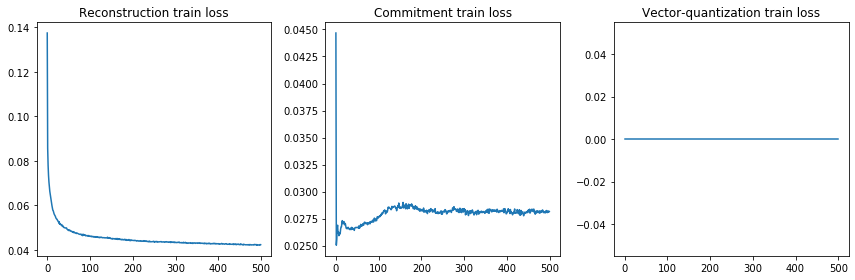

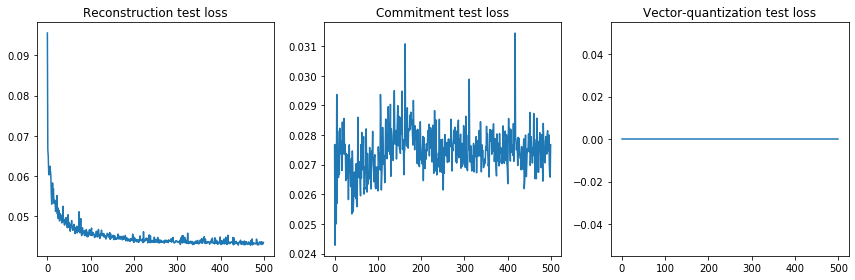

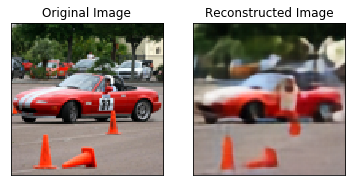

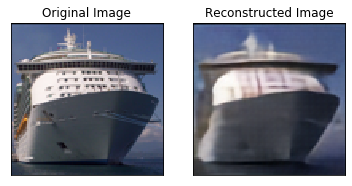

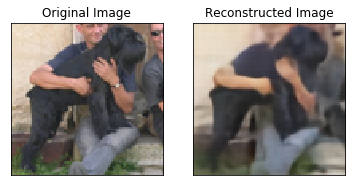

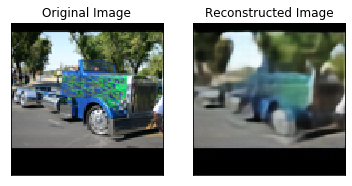

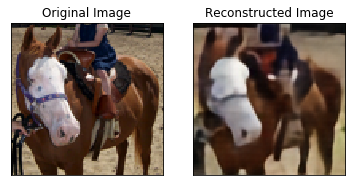

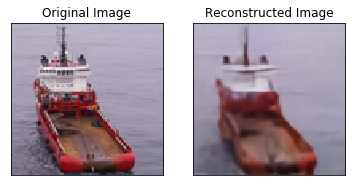

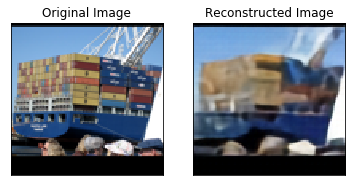

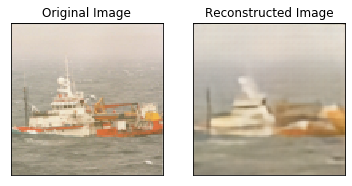

In [8]:
train()